In [1]:
from sklearn import svm
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

    return ax

### Importar imágenes

In [2]:
cow_img = Image.open("data/cow.jpg")
cow_mat = np.asarray(cow_img)

print(cow_mat.shape)

cielo_img = Image.open("data/cielo.jpg")
cielo_mat = np.asarray(cielo_img)

pasto_img = Image.open("data/pasto.jpg")
pasto_mat = np.asarray(pasto_img)

vaca_img = Image.open("data/vaca.jpg")
vaca_mat = np.asarray(vaca_img)

(760, 1140, 3)


### Construir set de datos

In [3]:
VACA = 0
CIELO = 1
PASTO = 2

v_x = vaca_mat.reshape(-1, vaca_mat.shape[-1])
v_y = np.empty(len(v_x))
v_y.fill(VACA)

c_x = cielo_mat.reshape(-1, cielo_mat.shape[-1])
c_y = np.empty(len(c_x))
c_y.fill(CIELO)

p_x = pasto_mat.reshape(-1, pasto_mat.shape[-1])
p_y = np.empty(len(p_x))
p_y.fill(PASTO)

xs = np.concatenate((v_x, c_x, p_x))
ys = np.concatenate((v_y, c_y, p_y))

x_train, x_test, y_train, y_test = train_test_split(xs, ys, test_size=0.33, random_state=42)

# TODO: hacer con varios núcleos, varios C

### Entrenamiento

In [4]:
clf = svm.SVC(gamma = 'scale')
clf.fit(x_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

### Predicción

In [5]:
test_pred = clf.predict(x_test)
test_true = y_test

### Métricas

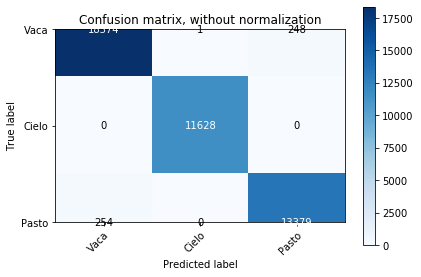

In [6]:
plot_confusion_matrix(test_true, test_pred, classes=['Vaca', 'Cielo', 'Pasto'])

## Overlay sobre la imagen original
Pinto una sombra de color sobre los píxeles de la imagen original para visualizar como los clasifica el SVM

In [15]:
def overlay_pixel(color, alpha, pixel):
    color = color * alpha
    pixel = pixel * (1 - alpha)
    return np.array(pixel + color).astype('uint8')

CLASS_COLORS = { 
    0: np.array([255, 0, 0]), # RED
    1: np.array([0, 0, 255]), # BLUE
    2: np.array([0, 255, 0])  # GREEN
}

In [18]:
flat_cow_mat = np.array(cow_mat.reshape(-1, cow_mat.shape[-1]))
prediction_mat = clf.predict(flat_cow_mat)
overlayed = np.array([overlay_pixel(CLASS_COLORS[pred], 0.3, pixel) for pred, pixel in zip(prediction_mat, flat_cow_mat)])

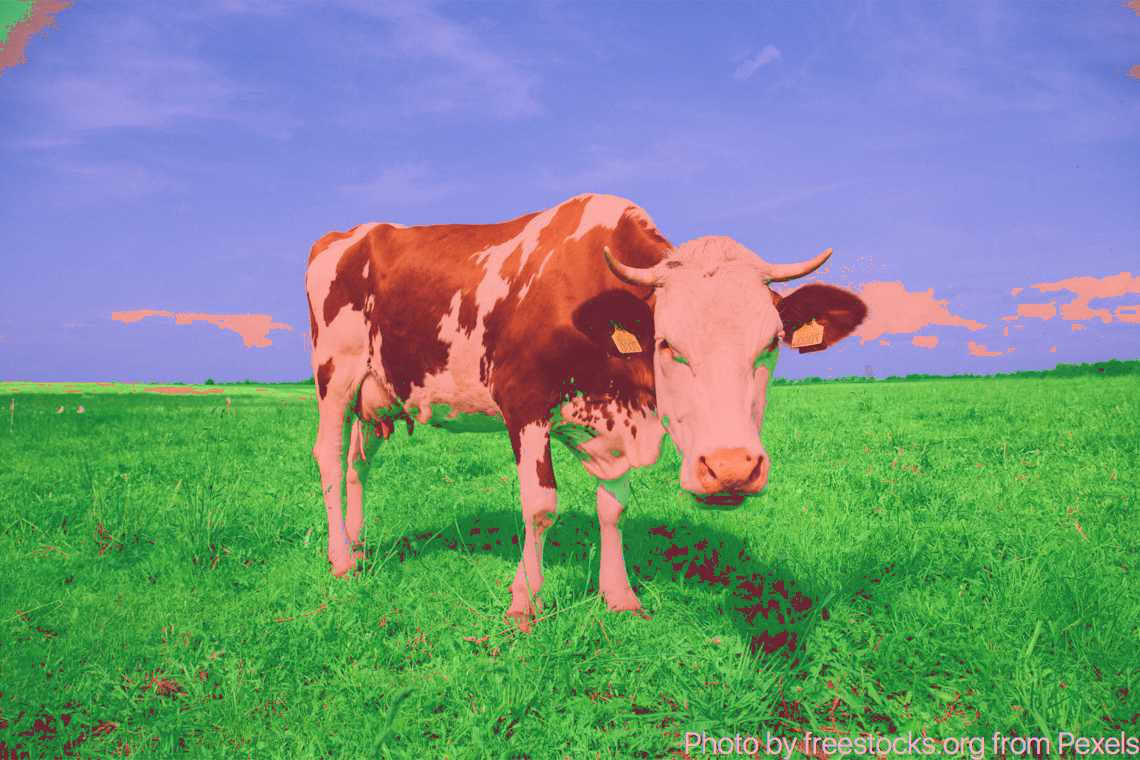

In [19]:
# Draw
overlayed = overlayed.reshape(760, 1140, 3)
Image.fromarray(overlayed)